<a href="https://colab.research.google.com/github/amanichivilkar/Articles-Recommendation-System/blob/main/Amani_Chivilkar_Articles_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Collaborative Filtering - Model-based**
--------
Model-based
In this approach, models are developed using different machine learning algorithms to recommend items to users. There are many model-based CF algorithms, like Neural Networks, Bayesian Networks, Clustering Techniques, and Latent Factor Models such as Singular Value Decomposition (SVD) and Probabilistic Latent Semantic Analysis.

## Loading data: CI&T Deskdrop dataset And import Libraries

* ### In this section, we load the Data, which contains a real sample of 12 months logs (Mar'16 - Feb'17) from CI&T's Internal Communication platform (DeskDrop). It contains about 73k logged users interactions on more than 3k public articles shared in the platform. CI&T is a nearshore information technology and software engineering company based out of Brazil

In [ ]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
import seaborn as sns 
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

## <u> shared_articles.csv </u>

* This file contains information about the articles shared in the platform. Each article has its sharing date (timestamp), the original url, title, content in plain text, the article' lang (Portuguese: pt or English: en) and information about the user who shared the article (author).



* There are two possible event types at a given timestamp - (i) CONTENT SHARED: The article was shared in the platform and is available for users (ii) CONTENT REMOVED: The article was removed from the platform and not available for further recommendation.



* For the sake of simplicity, we only consider here the "CONTENT SHARED" event type, assuming (naively) that all articles were available during the whole one year period. For a more precise evaluation (and higher accuracy), only articles that were available at a given time should be recommended, but we let this exercice for you.

In [ ]:
article = pd.read_csv('/content/drive/MyDrive/data/Copy of shared_articles.csv')
article = article[article['eventType'] == 'CONTENT SHARED']
article.head(2)

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en


In [ ]:
# a=set(article['contentId'])
# len(a)

In [ ]:
# b=set(df['contentId'])
# len(b)

In [ ]:
# len(a.intersection(b))

## <u> users_interactions.csv </u>

This file contains logs of user interactions on shared articles. It can be joined to **articles_shared.csv** by **contentId** column.

The eventType values are:  
- **VIEW**: The user has opened the article. 
- **LIKE**: The user has liked the article. 
- **COMMENT CREATED**: The user created a comment in the article. 
- **FOLLOW**: The user chose to be notified on any new comment in the article. 
- **BOOKMARK**: The user has bookmarked the article for easy return in the future.

In [ ]:
interactions = pd.read_csv('/content/drive/MyDrive/data/Copy of users_interactions.csv')
interactions.head(2)

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US


## **Data Preprocessing**

In [ ]:
event_type_strength = {'VIEW': 1.0,'LIKE': 2.0, 'BOOKMARK': 2.5, 'FOLLOW': 3.0,'COMMENT CREATED': 4.}

interactions['eventStrength'] = interactions['eventType'].apply(lambda x: event_type_strength[x])
interactions.head()

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry,eventStrength
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN,1.0
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US,1.0
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN,1.0
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN,3.0
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN,1.0


In [ ]:
# person intraction with number of unique content
df3 = interactions.groupby(['personId', 'contentId']).size().groupby('personId').size()
print(len(df3))
df3.head()

1895


personId
-9223121837663643404    43
-9212075797126931087     5
-9207251133131336884     7
-9199575329909162940    11
-9196668942822132778     7
dtype: int64

In [ ]:
# person intraction with >= 5 content
df4=df3[df3 >= 5].reset_index()[['personId']]
print(len(df4))
df4.head()

1140


,personId
0,-9223121837663643404
1,-9212075797126931087
2,-9207251133131336884
3,-9199575329909162940
4,-9196668942822132778


In [ ]:
interactions = interactions.merge(df4,on = 'personId')
print(len(interactions))
interactions.head()

69868


,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry,eventStrength
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN,1.0
1,1465413046,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5...,SP,BR,1.0
2,1464190235,VIEW,6437568358552101410,-8845298781299428018,-1157447994463607871,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4...,SP,BR,1.0
3,1459429221,VIEW,-4760639635023250284,-8845298781299428018,-5149610736659242149,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4...,SP,BR,1.0
4,1459274156,VIEW,-6142462826726347616,-8845298781299428018,-6283148774987755959,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4...,SP,BR,1.0


In [ ]:
df=interactions.groupby(['personId', 'contentId'])['eventStrength'].sum().reset_index()
df.head()

,personId,contentId,eventStrength
0,-9223121837663643404,-8949113594875411859,1.0
1,-9223121837663643404,-8377626164558006982,1.0
2,-9223121837663643404,-8208801367848627943,1.0
3,-9223121837663643404,-8187220755213888616,1.0
4,-9223121837663643404,-7423191370472335463,8.0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


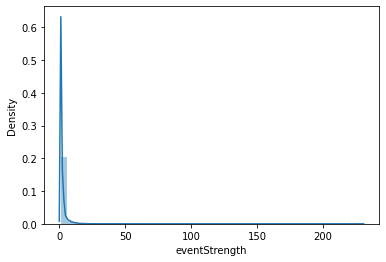

In [ ]:
sns.distplot(df['eventStrength'])

In [ ]:
# We will make all the distrubution into normal distribution using yeo-johnson
from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(np.log1p)

normal_event_Strength = transformer.fit_transform(df['eventStrength'].values.reshape(-1, 1))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


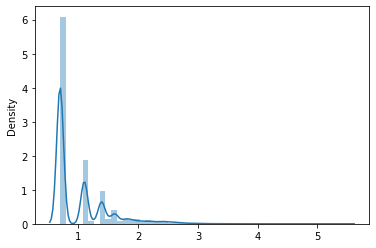

In [ ]:
sns.distplot(normal_event_Strength)

## **Final dataframe**

In [ ]:
df['normal_event_Strength']=normal_event_Strength
print(len(df))
df.head()

39106


,personId,contentId,eventStrength,normal_event_Strength
0,-9223121837663643404,-8949113594875411859,1.0,0.693147
1,-9223121837663643404,-8377626164558006982,1.0,0.693147
2,-9223121837663643404,-8208801367848627943,1.0,0.693147
3,-9223121837663643404,-8187220755213888616,1.0,0.693147
4,-9223121837663643404,-7423191370472335463,8.0,2.197225


## **Train Test Split**

In [ ]:
#Befor splitting df we need to remove user_id with one value count
x=df[['personId']].value_counts().reset_index()
x.tail(2)

,personId,0
1138,-6364723726238328437,5
1139,7072373334511597461,5


*  ther is no person_id with 1 value count so we split

In [ ]:
# Traintest split
train_df, test_df = train_test_split(df, stratify=df['personId'], test_size=0.20, random_state=42)

## **Applying Singular Value Decomposition (SVD)**

In [ ]:
#Creating a sparse pivot table with users in rows and items in columns
matrix_df = train_df.pivot(index='personId', columns='contentId',  values='normal_event_Strength').fillna(0)
print(len(matrix_df))
matrix_df.head()

1140


contentId,-9222795471790223670,-9216926795620865886,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9176143510534135851,-9172673334835262304,-9171475473795142532,-9166778629773133902,-9161596996229760398,-9160910454530522563,-9157338616628196758,-9153494109165200346,-9147114693160126293,-9137036168156595470,-9128741757954228992,-9128652074338368262,-9107331682787867601,-9105040345021932755,-9103776596534246502,-9102431381393428051,-9100490342054218852,-9099155556042679205,-9095002324981651252,-9092333155845304874,-9090514312860140897,-9089854794058353436,-9086955082453789880,-9083294960368598209,-9081753261356157170,-9080873096647717414,-9076501258717815738,-9073210245497295284,-9071883412530082330,-9064100704535292718,-9056114023474725450,-9055044275358686874,-9050450867630628092,-9045753673721269477,...,8962537427807366481,8963770574956550187,8963938873430212934,8968837261991914049,8969476626572775042,8974280745225397183,8982094176562780806,8993230615635349817,9004099881383415529,9026402401132606773,9028580484484026894,9032993320407723266,9033884391004475493,9038543365726770177,9042192299854648021,9045808098977760576,9054050762437897017,9056727675613132316,9060231864899459154,9079880752026843473,9091641298512813712,9112765177685685246,9121100366909552616,9122627895188486603,9124439338148818380,9128267824356972069,9136323715291453594,9151634133568930081,9168028029170358424,9175693555063886126,9191014301634017491,9207286802575546269,9208127165664287660,9209629151177723638,9209886322932807692,9213260650272029784,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
personId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-9223121837663643404,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9212075797126931087,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9207251133131336884,0.0,1.386294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9199575329909162940,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9196668942822132778,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.609438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15

#Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(matrix_df.values, k = NUMBER_OF_FACTORS_MF)

In [ ]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

In [ ]:
A=np.dot(np.dot(U, sigma), Vt) 
A

array([[ 0.00720814,  0.00056749, -0.01195861, ...,  0.00097531,
         0.00766946,  0.00156695],
       [-0.00013368, -0.00021708, -0.00183423, ...,  0.00174436,
         0.00012206, -0.00131343],
       [-0.00869706,  0.0045711 , -0.00409426, ...,  0.00484492,
        -0.00704027,  0.00800289],
       ...,
       [-0.02076239,  0.00558479, -0.01279763, ..., -0.00750733,
        -0.00082201,  0.00670953],
       [-0.01279207,  0.00323713,  0.00845364, ...,  0.00283848,
         0.00013504, -0.00521636],
       [-0.01044139,  0.00227166,  0.09282121, ..., -0.00826103,
         0.04451442,  0.0090334 ]])

## **Recommended_df**

In [ ]:
#Converting the reconstructed matrix back to a Pandas dataframe
Recommended_df = pd.DataFrame(A, columns = matrix_df.columns, index=matrix_df.index).transpose()
Recommended_df.head()

personId,-9223121837663643404,-9212075797126931087,-9207251133131336884,-9199575329909162940,-9196668942822132778,-9188188261933657343,-9172914609055320039,-9156344805277471150,-9120685872592674274,-9109785559521267180,-9063420486253202900,-9060214117327732109,-9047547311469006438,-9016528795238256703,-9009798162809551896,-9001583565812478106,-8994220765455693336,-8909668725653743114,-8891033171626175843,-8860671864164757449,-8854674432071487111,-8853658195208337106,-8845298781299428018,-8830250090736356260,-8823950498314351783,-8802075878443651241,-8784674845716296727,-8781635134606732409,-8781306637602263252,-8763398617720485024,-8738496712327699923,-8719462623048086192,-8704807962619440953,-8699750646678621887,-8694104221113176052,-8686631410634491662,-8674958742744576254,-8672331451814079632,-8670749047273764903,-8652741825481604192,...,8791271631167250981,8801420707973230165,8801970869404590779,8813266398846460512,8841741572929644986,8847054836611412804,8855523843512271162,8862260182894039021,8872819156169667456,8874741321583329336,8879844298911979276,8892482595912468268,8907499588729810535,8913362709216003291,8920667914865172372,8940614478925413056,8941502917401491878,8961723342122872302,8965285988346645117,8968131284214320024,8982783231149017560,8992729171160464416,9013651444868609421,9033898219489253274,9037410398700100618,9038446466275805109,9050204922960952289,9090527742744334314,9091970136990402395,9102085903669288476,9105269044962898535,9109075639526981934,9135582630122950040,9137372837662939523,9148269800512008413,9165571805999894845,9187866633451383747,9191849144618614467,9199170757466086545,9210530975708218054
contentId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-9222795471790223670,0.007208,-0.000134,-0.008697,0.036708,-0.006956,-0.003751,-0.002716,0.034173,-0.009329,-0.013899,-0.006605,0.001086,-0.008348,-0.045148,0.078150,0.028494,-0.007265,-0.003672,-0.024180,-0.085269,-0.006167,-0.029450,0.288666,-0.023309,-0.002525,-0.000297,-0.005120,-0.005207,0.004322,0.040395,-0.019831,0.029774,0.000063,-0.005643,0.092912,-0.002303,0.022349,-0.022968,-0.027161,0.001320,...,0.000123,0.014161,-0.012876,0.015979,-0.016703,-0.005098,0.009458,-0.012672,-0.010341,-0.006593,-0.013470,0.000057,-0.002258,-0.001803,0.003169,-0.011829,0.000859,-0.001303,-0.001725,0.354030,-0.005164,-0.012635,-0.003396,-0.006757,0.001979,0.002300,-0.004950,-0.004310,0.006510,0.021464,-0.003678,-0.062011,-0.000033,0.010413,0.014523,-0.006512,-0.013249,-0.020762,-0.012792,-0.010441
-9216926795620865886,0.000567,-0.000217,0.004571,-0.000450,0.000105,0.000235,0.000137,0.000597,0.001623,0.001224,0.000480,-0.000278,-0.000917,0.011434,0.006787,0.003851,0.003325,0.001385,0.005932,0.025593,0.003726,0.013380,-0.006384,-0.000028,0.000633,0.000473,0.001272,0.000134,0.002250,0.006434,0.000878,0.002298,-0.000060,0.005054,0.001030,0.000191,0.006410,0.004690,0.006929,-0.000424,...,0.000339,0.000919,0.000183,0.001683,0.001971,-0.001225,0.002277,0.003180,0.003535,-0.000086,0.002910,0.001291,0.000934,-0.000645,0.011174,0.002231,0.001083,0.001500,0.000472,0.017290,-0.000287,0.001945,-0.000327,0.001685,-0.000556,0.001712,0.000537,-0.000075,0.000944,-0.000376,0.000066,0.009645,0.000351,0.001012,0.010302,0.000652,0.001657,0.005585,0.003237,0.002272
-9194572880052200111,-0.011959,-0.001834,-0.004094,-0.002541,0.014764,-0.000886,0.020171,-0.010210,-0.016226,0.003431,0.017691,0.004648,0.011250,-0.059417,0.040838,0.020776,-0.001892,0.008394,-0.001565,0.010719,-0.001610,0.112753,-0.076424,0.029852,0.002698,0.001648,0.013946,-0.000685,0.066420,0.055165,-0.010312,0.023278,0.003016,0.016307,-0.039863,0.003720,0.057299,0.011187,0.055391,0.015393,...,-0.000398,0.009201,-0.004092,-0.007090,0.009603,0.011712,0.053730,-0.002447,0.030680,0.010485,0.039694,0.022833,0.008299,0.006701,0.003793,-0.015799,0.008180,0.001105,-0.001446,0.073724,0.000375,0.008808,-0.005301,-0.001176,-0.000934,0.014273,0.003471,0.000983,0.011092,-0.006978,0.007991,0.031893,

## **STEPS To recomment item to a user**




In [ ]:
# Indexing the User-ID to speed up the searches during evaluation
df = df.set_index('personId')
train_df = train_df.set_index('personId')
test_df = test_df.set_index('personId')

In [ ]:
# Getting a ranked recommendation list from the model for a given user
def Recommended_book_for_a_user_df(user_id):
     
    # User read book from the train_df
    user_read_book=set(train_df.loc[user_id]['contentId'])

    # Consider single "USER 254" column containig its predicted rating and sort this ratings in decending order
    df1=Recommended_df[user_id].sort_values(ascending=False).reset_index().rename(columns={user_id: 'ratings'})
    
    # From above recommended books remove user_read_book
    Recommended_book_for_a_user_df= df1[~df1['contentId'].isin(user_read_book)].sort_values('ratings', ascending = False)
    
    return Recommended_book_for_a_user_df

In [ ]:
# Ranked Recommended Dataframe of a User 
user_id=-9223121837663643404
Recommended_book_for_a_user_df(user_id).head()

,contentId,ratings
0,-8208801367848627943,0.275304
2,3149164017776669829,0.176580
3,2072448887839540892,0.173559
4,-4029704725707465084,0.157413
5,5238119115012015307,0.153046
